# Pipeline visualization

This notebook demonstrates how to visualize a pipeline build with *nimbusml*.

## Data

We consider a very small dataset with tweets.

In [1]:
data = """
"ItemID","Sentiment","SentimentSource","SentimentText","RowNum","Positive","Train","Small"
1,0,"Sentiment140","is so sad for my APL friend.............",1,FALSE,TRUE,FALSE
2,0,"Sentiment140","I missed the New Moon trailer...",2,FALSE,TRUE,FALSE
3,1,"Sentiment140","omg its already 7:30 :O",3,TRUE,TRUE,FALSE
4,0,"Sentiment140",".. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...",4,FALSE,TRUE,FALSE
5,0,"Sentiment140","i think mi bf is cheating on me!!!       T_T",5,FALSE,TRUE,FALSE
6,0,"Sentiment140","or i just worry too much?",6,FALSE,TRUE,FALSE
7,1,"Sentiment140","Juuuuuuuuuuuuuuuuussssst Chillin!!",7,TRUE,TRUE,FALSE
8,0,"Sentiment140","Sunny Again        Work Tomorrow  :-|       TV Tonight",8,FALSE,TRUE,FALSE
9,1,"Sentiment140","handed in my uniform today . i miss you already",9,TRUE,TRUE,FALSE
"""

In [2]:
with open("data_train.csv", "w") as f:
    f.write(data.replace("\t", ","))

In [3]:
import pandas
df = pandas.read_csv("data_train.csv")
df.head(n=2)

,ItemID,Sentiment,SentimentSource,SentimentText,RowNum,Positive,Train,Small
0,1,0,Sentiment140,is so sad for my APL friend.............,1,False,True,False
1,2,0,Sentiment140,I missed the New Moon trailer...,2,False,True,False


In [4]:
from nimbusml import FileDataStream
stream = FileDataStream.read_csv("data_train.csv")
stream.schema

DataSchema([DataColumn(name='ItemID', type='I8', pos=0),
    DataColumn(name='Sentiment', type='I8', pos=1),
    DataColumn(name='SentimentSource', type='TX', pos=2),
    DataColumn(name='SentimentText', type='TX', pos=3),
    DataColumn(name='RowNum', type='I8', pos=4),
    DataColumn(name='Positive', type='BL', pos=5),
    DataColumn(name='Train', type='BL', pos=6),
    DataColumn(name='Small', type='BL', pos=7)], header=True)

## A pipeline

The following pipeline includes a couple of transform to process and convert text into numerical features.

In [5]:
from nimbusml.feature_extraction.text import NGramFeaturizer, ngramfeaturizer
from nimbusml.preprocessing.schema import ColumnConcatenator
from nimbusml.feature_extraction.categorical import OneHotVectorizer
from nimbusml.ensemble import FastTreesBinaryClassifier
from nimbusml import Pipeline, FileDataStream, Role

transform_1 = NGramFeaturizer() << {'transformed1':'SentimentText'}
transform_2 = OneHotVectorizer() << 'SentimentSource'
transform_3 = ColumnConcatenator() << {'finalfeatures': ['transformed1', 'SentimentSource']}
algo = FastTreesBinaryClassifier() << {Role.Feature:'finalfeatures', Role.Label: "Positive"}

pipeline = Pipeline([transform_1, transform_2, transform_3, algo])

Method *get_fit_info* gives information on input, output for each transfrom and learner of the pipeline. The output is a list of dictionaries, each of them describes one element of the pipeline.

In [6]:
import pprint
pprint.pprint(pipeline.get_fit_info(stream)[0])

[{'name': None,
  'operator': None,
  'outputs': ['ItemID',
              'Sentiment',
              'SentimentSource',
              'SentimentText',
              'RowNum',
              'Positive',
              'Train',
              'Small'],
  'schema_after': ['ItemID',
                   'Sentiment',
                   'SentimentSource',
                   'SentimentText',
                   'RowNum',
                   'Positive',
                   'Train',
                   'Small'],
  'type': 'start'},
 {'inputs': ['SentimentText'],
  'name': 'NGramFeaturizer',
  'operator': NGramFeaturizer(char_feature_extractor=None,
        columns={'transformed1': 'SentimentText'}, dictionary=None,
        keep_diacritics=False, keep_numbers=True, keep_punctuations=True,
        language='English', output_tokens=False, stop_words_remover=None,
        text_case='Lower', vector_normalizer='L2',
        word_feature_extractor={'Name': 'NGram', 'Settings': {'NgramLength': 1, 'SkipLength': 

## Graph representation

Previous information can be summarized in a nice graph much easier to read. The graph is described with the [DOT](https://en.wikipedia.org/wiki/DOT_(graph_description_language)) language. That's what the function *dot_export_pipeline* does.

In [7]:
from nimbusml.utils.exports import dot_export_pipeline
dot_vis = dot_export_pipeline(pipeline, stream)
print(dot_vis)

digraph{
  orientation=portrait;
  sch0[label="<f0> ItemID|<f1> Sentiment|<f2> SentimentSource|<f3> SentimentText|<f4> RowNum|<f5> Positive|<f6> Train|<f7> Small",shape=record,fontsize=8];

  node1[label="NGramFeaturizer",shape=box,style="filled,rounded",color=cyan,fontsize=12];
  sch0:f3 -> node1;
  sch1[label="<f0> transformed1|<f1> transformed1_TransformedText",shape=record,fontsize=8];
  node1 -> sch1:f0;
  node1 -> sch1:f1;

  node2[label="OneHotVectorizer",shape=box,style="filled,rounded",color=cyan,fontsize=12];
  sch0:f2 -> node2;
  sch2[label="<f0> SentimentSource",shape=record,fontsize=8];
  node2 -> sch2:f0;

  node3[label="ColumnConcatenator",shape=box,style="filled,rounded",color=cyan,fontsize=12];
  sch1:f0 -> node3;
  sch2:f0 -> node3;
  sch3[label="<f0> finalfeatures",shape=record,fontsize=8];
  node3 -> sch3:f0;

  node4[label="FastTreesBinaryClassifier",shape=box,style="filled,rounded",color=yellow,fontsize=12];
  sch3:f0 -> node4 [label="Feature",fontsize=8];
  sch0:

## Visualize with graphviz

[graphviz](https://www.graphviz.org/) is one tool often used to represent a graph described with the DOT language. In nimbusml, we can convert this DOT file to image and also save it to a file.
To use graphviz in this notebook, download the executables from https://graphviz.gitlab.io/download/, add them to your system path, and then run "pip install graphviz".

In [8]:
import os
import sys


def install_and_import(package):
    import importlib
    try:
        importlib.import_module(package)
    except ImportError:
        import pip
        pip.main(
            ['install', package])
    finally:
        globals()[package] = importlib.import_module(package)


install_and_import('graphviz')

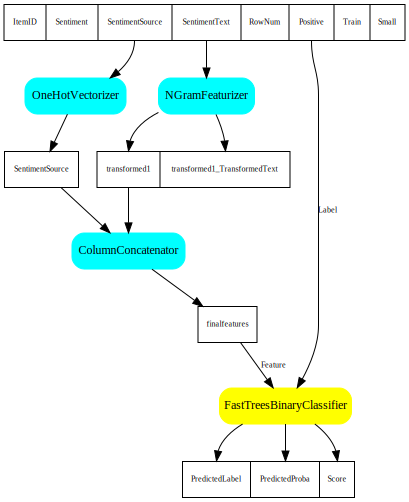

In [9]:
from nimbusml.utils.exports import img_export_pipeline
fig = img_export_pipeline(pipeline, stream)
fig.render('pipeline_visual')
fig

Let's give some insights on what it represents.

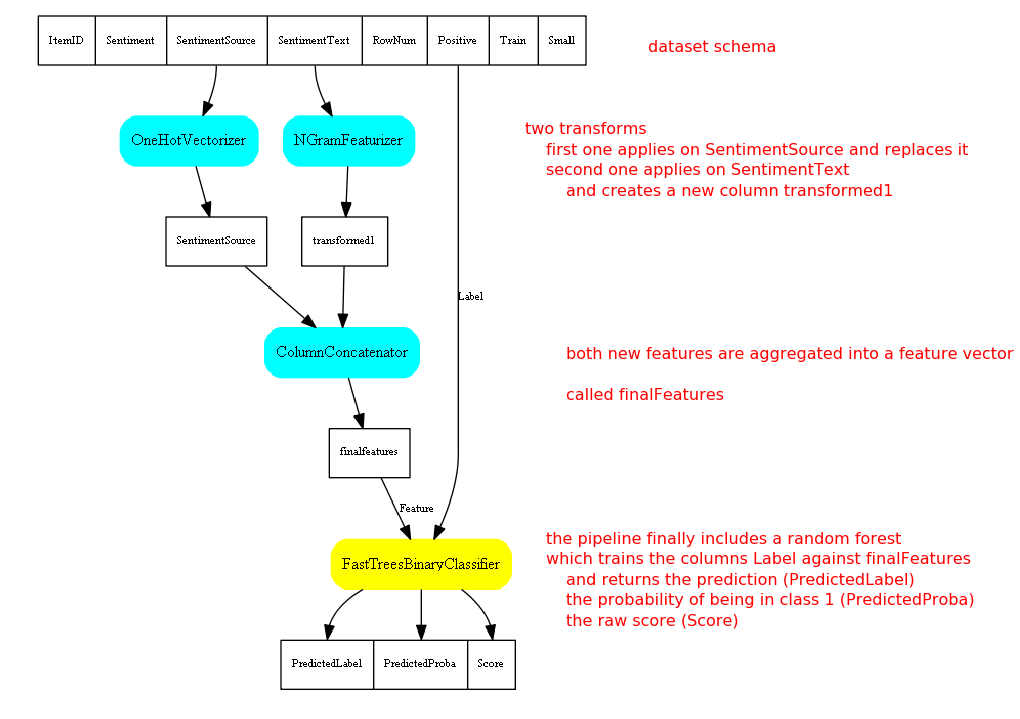

In [10]:
%matplotlib inline
import matplotlib.image as mpimg
img = mpimg.imread('images/pipeline.gv.png')

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10,14), frameon=False)
ax.imshow(img)
ax.text(600, 40, "dataset schema", fontsize=16, color="r")
ax.text(480, 120, "two transforms", fontsize=16, color="r")
ax.text(500, 140, "first one applies on SentimentSource and replaces it", fontsize=16, color="r")
ax.text(500, 160, "second one applies on SentimentText ", fontsize=16, color="r")
ax.text(520, 180, "and creates a new column transformed1", fontsize=16, color="r")
ax.text(520, 340, "both new features are aggregated into a feature vector", fontsize=16, color="r")
ax.text(520, 380, "called finalFeatures", fontsize=16, color="r")
ax.text(500, 520, "the pipeline finally includes a random forest", fontsize=16, color="r")
ax.text(500, 540, "which trains the columns Label against finalFeatures", fontsize=16, color="r")
ax.text(520, 560, "and returns the prediction (PredictedLabel)", fontsize=16, color="r")
ax.text(520, 580, "the probability of being in class 1 (PredictedProba)", fontsize=16, color="r")
ax.text(520, 600, "the raw score (Score)", fontsize=16, color="r")
ax.axis('off');

## Visualize with viz.js

There exists a javascript alternative to *graphivz* which does not requiree installation but only works in a notebook:
[viz.js](https://github.com/mdaines/viz.js/).

In [11]:
%%html

<div id="dotgraph" style="width:100%;height:100%;"></div></div>
<script>

require(['http://viz-js.com/bower_components/viz.js/viz.js'], function() { 
    var svgGraph = Viz("digraph{\n  orientation=portrait;\n  sch0[label=\"<f0> ItemID|<f1> Sentiment|<f2> SentimentSource|<f3> SentimentText|<f4> RowNum|<f5> Positive|<f6> Train|<f7> Small\",shape=record,fontsize=8];\n\n  node1[label=\"NGramFeaturizer\",shape=box,style=\"filled,rounded\",color=cyan,fontsize=12];\n  sch0:f3 -> node1;\n  sch1[label=\"<f0> transformed1\",shape=record,fontsize=8];\n  node1 -> sch1:f0;\n\n  node2[label=\"OneHotVectorizer\",shape=box,style=\"filled,rounded\",color=cyan,fontsize=12];\n  sch0:f2 -> node2;\n  sch2[label=\"<f0> SentimentSource\",shape=record,fontsize=8];\n  node2 -> sch2:f0;\n\n  node3[label=\"ColumnConcatenator\",shape=box,style=\"filled,rounded\",color=cyan,fontsize=12];\n  sch1:f0 -> node3;\n  sch2:f0 -> node3;\n  sch3[label=\"<f0> finalfeatures\",shape=record,fontsize=8];\n  node3 -> sch3:f0;\n\n  node4[label=\"FastTreesBinaryClassifier\",shape=box,style=\"filled,rounded\",color=yellow,fontsize=12];\n  sch3:f0 -> node4 [label=\"Feature\",fontsize=8];\n  sch0:f5 -> node4 [label=\"Label\",fontsize=8];\n  sch4[label=\"<f0> PredictedLabel|<f1> PredictedProba|<f2> Score\",shape=record,fontsize=8];\n  node4 -> sch4:f0;\n  node4 -> sch4:f1;\n  node4 -> sch4:f2;\n}");
    document.getElementById('dotgraph').innerHTML = svgGraph; 
});

</script>

## In a function

If you have many pipeline to draw.

In [12]:
from nimbusml.utils.exports import dot_export_pipeline
from jinja2 import Template
import uuid
from IPython.display import HTML


template = Template("""    
<div id="{{divid}}" style="width:{{width}};height:{{height}};"></div></div>
<script>

require(['http://viz-js.com/bower_components/viz.js/viz.js'], function() { 
    var dot = '{{dot}}';
    var svgGraph = Viz(dot);
    document.getElementById('{{divid}}').innerHTML = svgGraph; 
});

</script>
""")


def display_pipeline(pipeline, stream, divid=None, width="100%", height="100%"):
    global template
    if divid is None:
        divid = uuid.uuid4()
    dot = dot_export_pipeline(pipeline, stream)
    html = template.render(dot=dot.replace("\n", "\\n"), divid=divid,
                           width=width, height=height)
    return HTML(html)

display_pipeline(pipeline, stream)